In [146]:
import re
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

%matplotlib notebook

In [20]:
def extractFromHTML(filePath):
    # extracting data from HTML file 

    # reading data
    # f = open("Data\\view-source_https___www.espn.com_nba_team_schedule___name_det_season_2003_seasontype_2.html", "r")
    f = open(filePath, "r")
    data = f.read()
    data = data.replace('\n', '')

    # extraccting the table
    pattern = "<tr.+>.+</tr>"
    table = re.search(pattern, data)

    # extracting all rows into an array rows
    rows = table.group(0).split("</tr>")

    # deciding if its a home game or visiting game
    # if 
    # (1) vs after vs make distance = 0
    # (2) vs after @  calculate distance
    # (3) @  after vs calculate distance
    # (4) @  after @  calculate distance
    pattern = '(?<=<span class="pr2">)(.{1,2})(?=</span>)'
    gameLocations = re.findall(pattern, data)

    teamTitles = []
    rows = rows[1:-1]
    for row in rows:
        # extraccting the team for each row
        pattern = '(?<=<div class="flex items-center opponent-logo">)(.+)(?=</div>)'
        teamInformation = re.search(pattern, row)

        # extracting team title
        pattern = '(?<=title=")(.*?)(?=")'
        teamTitle = re.findall(pattern, teamInformation.group(0))
        if (len(teamTitle) > 0):
            teamTitles.append(teamTitle[0])
        else:
            pattern = '(?<=<div class="flex items-center opponent-logo">)(.+?)(?=</div>)'
            a = re.findall(pattern, row)
            pattern = '(?<=<span>)([A-Za-z\s]+?)(?=</span>)'
            teamTitle = re.findall(pattern, a[0])
            teamTitles.append(teamTitle[0])

    # Extracting whther the team win or lose
    pattern = '(?<=<span class="fw-bold clr-[a-z]{8}">)([A-Z]?)(?=</span>)'
    winOrLose = re.findall(pattern, data)

    df = pd.DataFrame({'Location':gameLocations, 'Opponent Title':teamTitles, 'Game Result':winOrLose})
    f.close()
    return df

In [46]:
# Distionary of the team current official names and base cities for the purpose of distance estimation
teamFull = {
    'San Antonio': ('San Antonio Spurs', 'San Antonio, Texas', 'San+Antonio,+TX'),
    'Boston'  : ('Boston Celtics', 'Boston, Massachusetts', 'Boston,+MA'),
    'Sacramento' : ('Sacramento Kings', 'Sacramento, California', 'Sacramento,+CA,+USA'),
    'Los Angeles': ('Los Angeles Clippers', 'Los Angeles, California', 'Los+Angeles,+CA,+USA'),
    'Golden State': ('Golden State Warriors', 'San Francisco, California', 'San+Francisco,+CA,+USA'),
    'Charlotte' : ('Charlotte Hornets', 'Charlotte, North Carolina', 'Charlotte,+NC,+USA'),
    'NO/Oklahoma City' : ('N/A', 'Oklahoma City, Oklahoma',  'Oklahoma+City,+OK,+USA'),
    'Oklahoma City' : ('Oklahoma City Thunder', 'Oklahoma City, Oklahoma', 'Oklahoma+City,+OK,+USA'),
    'Brooklyn': ('Brooklyn Nets', 'Brooklyn, New York', 'Brooklyn,+NY,+USA'), 
    'New York': ('New York Knicks', 'New York City, New York', 'New+York+City,+NY,+USA'),
    'Memphis' : ('Memphis Grizzlies', 'Memphis, Tennessee', 'Memphis,+TN,+USA'),
    'LA'      : ('Los Angeles Lakers', 'Los Angeles, California', 'Los+Angeles,+CA,+USA'),
    'Phoenix' : ('Phoenix Suns', 'Phoenix, Arizona', 'Phoenix,+AZ,+USA'),
    'Utah'    : ('Utah Jazz', 'Salt Lake City, Utah', 'Salt+Lake+City,+UT,+USA'),
    'Denver'  : ('Denver Nuggets', 'Denver, Colorado', 'Denver,+CO,+USA'),
    'Dallas'  : ('Dallas Mavericks', 'Dallas, Texas', 'Dallas,+TX,+USA'),
    'New Orleans' : ('New Orleans Pelicans', 'New Orleans, Louisiana', 'New+Orleans,+LA,+USA'),
    'Miami'   : ('Miami Heat', 'Miami, Florida', 'Miami,+FL,+USA'), 
    'Indiana' : ('Indiana Pacers', 'Indianapolis, Indiana', 'Indianapolis,+IN,+USA'), 
    'Milwaukee' : ('Milwaukee Bucks', 'Milwaukee, Wisconsin', 'Milwaukee,+WI,+USA'),
    'Washington': ('Washington Wizards', 'Washington, D.C.', 'Washington,+DC,+USA'),
    'Atlanta' : ('Atlanta Hawks', 'Atlanta, Georgia', 'Atlanta,+GA,+USA'),
    'Chicago' : ('Chicago Bulls', 'Chicago, Illinois', 'Chicago,+IL,+USA'),
    'Seattle' : ('Seattle SuperSonics', 'Seattle, Washington', 'Seattle,+WA,+USA'),
    'New Jersey' : ('Brooklyn Nets', 'Brooklyn, New York', 'Brooklyn,+NY,+USA'),
    'Cleveland'  : ('Cleveland Cavaliers', 'Cleveland, Ohio', 'Cleveland,+OH,+USA'), 
    'Orlando' : ('Orlando Magic', 'Orlando, Florida', 'Orlando,+FL,+USA'),
    'Minnesota' : ('Minnesota Timberwolves', 'Minneapolis, Minnesota', 'Minneapolis,+MN,+USA'),
    'Portland': ('Portland Trail Blazers', 'Portland, Oregon', 'Portland,+OR,+USA'),
    'Toronto' : ('Toronto Raptors', 'Toronto, Ontario', 'Toronto,+Canada'),
    'Philadelphia': ('Philadelphia 76ers', 'Philadelphia, Pennsylvania', 'Philadelphia,+PA,+USA'),
    'Houston' : ('Houston Rockets', 'Houston, Texas', 'Houston,+TX,+USA')
}

In [ ]:
# Credit: https://www.travelmath.com for providing distance estimation 
def getDistance(city1, city2):
    # result set to -1, so that the program can catch if anomally occur 
    flyingDistance = -1
    url = requests.get("https://www.travelmath.com/distance/from/" + city1 + "/to/" + city2)
    htmltext = url.text
    pattern = '(?<=<h3 class="space">)(.+?)(?=</h3>)'
    info = re.findall(pattern, htmltext)[0].split('</span>')
    for each in info:
        if(each.find('flying') != -1):
            flyingDistance = each.split('km')[0].strip().replace('&thinsp;', '')
    return flyingDistance

In [91]:
def getDistanceOnBatch(year):
    testDf = df[df.Year == year]
    previousLocation = testDf['Location'][0]
    # Based on assumption that the team must had gotten full resting before the 
    # first game of season, so the distance is made 0 in every year. 
    distance = [0]
    # initializing progress bar
    l = len(testDf)
    printProgressBar(1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    # Loop through the batch of games played in that year
    for i in range(1, len(testDf)):
        currentLocation = testDf['Location'][i]
        if( (previousLocation == 'vs') and (currentLocation == 'vs')):
            distance.append(0)
        else:
            if(previousLocation == 'vs'): 
                city1 = 'Detroit,+MI'
                city2 = teamFull[testDf['Opponent Title'][i]][-1]
            elif(currentLocation == 'vs'):
                city1 = teamFull[testDf['Opponent Title'][i-1]][-1]
                city2 = 'Detroit,+MI'
            else:
                city1 = teamFull[testDf['Opponent Title'][i-1]][-1]
                city2 = teamFull[testDf['Opponent Title'][i]][-1]
            distance.append(float(getDistance(city1, city2)))
            time.sleep(1)
        # update previous location to the current location, so that the next one can see previous one
        previousLocation = currentLocation
        
        # update progress bar
        printProgressBar(i+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    return distance

In [ ]:
# Print iterations progress
# Credit: Greenstick's post on https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [108]:
def exportDistanceBatch(year):
    # Used for exporting distances data, so that program doesn't need to retrieve 
    # distance information from www.travelmath.com again after the first run. 
    distanceYear = getDistanceOnBatch(year)
    dfYear = df[df.Year == year].copy()
    dfYear['Distance'] = distanceYear
    dfYear.to_csv('Data\\detroitNBA' + str(year) + '.csv')
    return dfYear

***

In [68]:
# initialize detrorit stats from 2003-2019 (2020 excluidng due to COVID19 situation)
# Note that data were manually downloaded as html files for convenient. This can also be automated 
# similar to how distance information retreived.  
df = extractFromHTML("Data\\view-source_https___www.espn.com_nba_team_schedule___name_det_season_2003_seasontype_2.html")
df['Year'] = 2003
print(str(2003) + " is done")
for year in range(2004, 2020):
    temp = extractFromHTML("Data\\view-source_https___www.espn.com_nba_team_schedule___name_det_season_" + str(year) + "_seasontype_2.html")
    temp['Year'] = year
    df = df.append(temp)
    print(str(year) + " is done")

2003 is done
2004 is done
2005 is done
2006 is done
2007 is done
2008 is done
2009 is done
2010 is done
2011 is done
2012 is done
2013 is done
2014 is done
2015 is done
2016 is done
2017 is done
2018 is done
2019 is done


In [98]:
dfWithDistance = exportDistanceBatch(2003)

,Location,Opponent Title,Game Result,Year,Distance
0,vs,New York,W,2003,0
1,vs,Memphis,W,2003,0
2,@,LA,L,2003,3192
3,@,Phoenix,W,2003,575
4,@,Utah,W,2003,812
...,...,...,...,...,...
77,vs,Orlando,W,2004,0
78,vs,Toronto,W,2004,0
79,@,Orlando,W,2004,1538
80,vs,Washington,W,2004,1538


In [111]:
for year in range(2004,2020):
    temp = exportDistanceBatch(year)
    dfWithDistance = dfWithDistance.append(temp)
    print('Year ' + str(year) + ' distance is done')
    time.sleep(120)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2008 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2009 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2010 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2011 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2012 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2013 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2014 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2015 distance is done
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Year 2016 distance is done
Progress: |███████████████████████████████████

In [140]:
# Checking if there is any anomally in distance estimation
dfWithDistance['Distance'] = dfWithDistance.Distance.apply(lambda x: float(x))
dfWithDistance = dfWithDistance.reset_index().drop('index', axis=1)
dfWithDistance[dfWithDistance.Distance < 0]

,Location,Opponent Title,Game Result,Year,Distance
1059,@,Los Angeles,L,2016,-1.0


In [141]:
# Inspecting what causes the anomally
dfWithDistance.loc[1058:1060]

,Location,Opponent Title,Game Result,Year,Distance
1058,@,LA,L,2016,581.0
1059,@,Los Angeles,L,2016,-1.0
1060,vs,Cleveland,W,2016,3192.0


In [142]:
# the error from get distance is simply becasue they are in the same city, so distance should be set 0
dfWithDistance.at[1059, 'Distance'] = 0

<IPython.core.display.Javascript object>


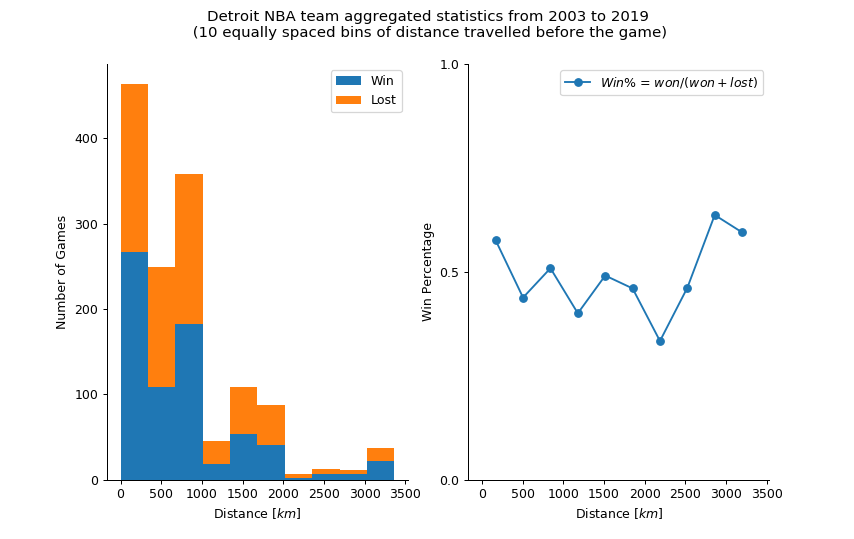

C:\Users\pui_s\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, 'Detroit NBA team aggregated statistics from 2003 to 2019\n (10 equally spaced bins of distance travelled before the game)')

In [261]:
dfForHist = dfWithDistance[['Game Result', 'Distance']]
won = dfForHist[dfForHist['Game Result'] == 'W']['Distance']
won.name = 'W'
lost = dfForHist[dfForHist['Game Result'] == 'L']['Distance']
lost.name = 'L'
# plot a kernel density estimation over a stacked barchart
fig = plt.figure(figsize=(9.5,6))

ax1 = plt.subplot(1, 2, 1)

(n, bins, _) = plt.hist([won, lost], histtype='barstacked', bins=10);
plt.xlabel('Distance [$km$]');
plt.ylabel('Number of Games');
plt.legend(['Win', 'Lost']);
# removing top and right figure's borders
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)


numberOfWin = n[0]
numberOfLost = n[1]-n[0]
winPercentage = numberOfWin/(numberOfWin+numberOfLost)
binsMiddle = 0.5*(bins[:-1]+bins[1:])
ax2 = plt.subplot(1, 2, 2, sharex=ax1)
plt.plot(binsMiddle, winPercentage, '-o', label='$Win\%$ = $won/(won + lost)$');
plt.legend();
plt.xlabel('Distance [$km$]');
plt.ylabel('Win Percentage');
plt.yticks([0, 0.5, 1.0]);
# removing top and right figure's borders
right_side = ax2.spines["right"]
right_side.set_visible(False)
top_side = ax2.spines["top"]
top_side.set_visible(False)

fig.suptitle('Detroit NBA team aggregated statistics from 2003 to 2019\n (10 equally spaced bins of distance travelled before the game)');
# save the figure for submission
fig.savefig("Data\\Plot10bins.png");